In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
import datetime
from datetime import timedelta
from functools import reduce

%matplotlib inline

# Import local modules
import load_files as lf
import measurement_analysis as ma
import wrangling as wr
import utility as ut
import time

In [2]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

pickle_in = open("/Users/blazejmanczak/Desktop/Q1/DataChallenge3/ma_df_all", "rb")
df = pickle.load(pickle_in)

level_data = wr.clean_mes_data(df.level_data)
flow_data = wr.clean_mes_data(df.flow_data)

level_data_not_imputed = wr.clean_mes_data(df.level_data)
flow_data_not_imputed = wr.clean_mes_data(df.flow_data)

flow_data, level_data = wr.merge_flow_level(flow_data, level_data)

In [3]:
na_indices = flow_data.index[flow_data["Value"].isna()]
non_na_indices = flow_data.index[~flow_data["Value"].isna()]

Number of NaN's:  424439
Number of Non-NaN's:  2880599


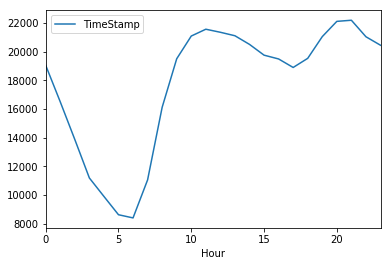

In [4]:
flow_data[['TimeStamp', 'Hour']].loc[na_indices].groupby('Hour').aggregate('count').plot()

print("Number of NaN's: ", len(na_indices))
print("Number of Non-NaN's: ", len(non_na_indices))

In [143]:
"""
prior_indices = ut.search_prior_indices(na_indices, non_na_indices).reset_index(drop=True) 
# a series with nan indicies as index

posterior_indices = ut.search_posterior_indices(na_indices, non_na_indices).reset_index(drop=True)


# TimeStamps of prior and posterior indices
ts_prior = flow_data.loc[prior_indices, "TimeStamp"]\
                     .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                     .reset_index(drop=True)
ts_posterior = flow_data.loc[posterior_indices, "TimeStamp"]\
                         .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                         .reset_index(drop=True)
ts_actual = flow_data.loc[level_data["Value"].isna(), "TimeStamp"]\
                      .apply(lambda i: (i - datetime.datetime(2017,1,1)).total_seconds())\
                      .reset_index(drop=True)
                      
ts_diff = ts_posterior - ts_prior
"""

KeyboardInterrupt: 

(0, 8000)

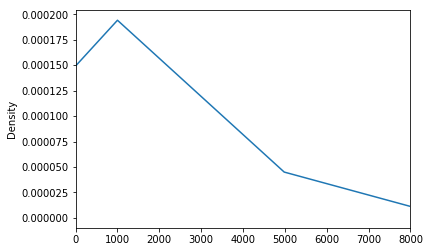

In [133]:
ax = (ts_posterior - ts_prior).plot(kind = 'density')
ax.set_xlim(0,8000) 
# we see that most of the missing timestamps  have a pretty big difference in time in between 

In [141]:
# How many times does the flow value jump significantly?

def how_many_jumps(threshold = 30, prior_indices = prior_indices, posterior_indices = posterior_indices, flow_data = flow_data):
    """ Indicates how many jumps bigger than threshold there are between prior and posterior"""
    if len(prior_indices) != len(posterior_indices):
        return 'Invalid input'
    
    flow_prior = flow_data.loc[prior_indices, 'Value'].reset_index(drop = True)
    flow_posterior = flow_data.loc[posterior_indices, 'Value'].reset_index(drop = True)
    flow_difference = flow_posterior - flow_prior
    #return flow_difference
    jumps = sum(abs(flow_difference) >= threshold)
    
    print("There are {} jumps".format(jumps))
    print('That consititutes {}% percentage of all missing values'.format(round(jumps/len(prior_indices), 4)*100))
    
    return 
        
        
how_many_jumps(threshold=0)

There are 424429 jumps
That consititutes 100.0% percentage of all missing values


In [40]:
flow_data.loc[prior_indices[100]:posterior_indices[100]]

,TimeStamp,RG_ID,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Flow,max,min,Dry
11459,2018-01-01 17:09:35,8150.0,0.347247,1.0,2018-01-01,17,1,0,5.0,0.200000,0.000482,0.0,0.0,1.0
11460,2018-01-01 17:09:40,NaN,NaN,NaN,2018-01-01,17,1,0,5.0,0.200000,NaN,NaN,NaN,NaN
11461,2018-01-01 17:09:55,NaN,NaN,NaN,2018-01-01,17,1,0,15.0,0.066667,NaN,NaN,NaN,NaN
11462,2018-01-01 17:10:15,NaN,NaN,NaN,2018-01-01,17,1,0,20.0,0.050000,NaN,NaN,NaN,NaN
11463,2018-01-01 17:10:40,NaN,NaN,NaN,2018-01-01,17,1,0,25.0,0.040000,NaN,NaN,NaN,NaN
11464,2018-01-01 17:11:10,NaN,NaN,NaN,2018-01-01,17,1,0,30.0,0.033333,NaN,NaN,NaN,NaN
11465,2018-01-01 17:11:40,NaN,NaN,NaN,2018-01-01,17,1,0,30.0,0.033333,NaN,NaN,NaN,NaN
11466,2018-01-01 17:12:10,NaN,NaN,NaN,2018-01-01,17,1,0,30.0,0.033333,NaN,NaN,NaN,NaN
11467,2018-01-01 17:12:40,NaN,NaN,NaN,2018-01-01,17,1,0,30.0,0.033333,NaN,NaN,NaN,NaN
11468,2018-01-01 17:13:10,NaN,NaN,NaN,2018-01-01,17,1,0,30.0,0.033333,NaN,NaN,NaN,NaN


## Algorithm in words: 
- naturally every timestamp for which flow is NaN has an entry in the level data as the missing timestamp comes from there. Note that within the flow data itself we do not have NaN's.
- check if the level is increasing, decreasing, or around extremum. If increasing and in bounds of on/off level, then value for flow 0. If the level is decreasing, around extremum or above the on level:

- compute the mean flow given around this level (some neighboorhood, eg. +- 0.1) across all level data
- get the flow data corresponding to these levels when level is decreasing
- if the std is not larger than $\frac{1}{2} \cdot$ mean_flow, plug this value in as impute prediction. Otherwise leave NA



In [5]:
def check_monotonicity(x, epsilon = 1):
    """ 
    Function that checks whether a list is increasing or
    decreasing with an epsilon terms that do not suit the pattern
    """
    #print(type(x))
    #print(x)
    dx = np.diff(x) # takes the difference of consecutive elements 
    positives = int(np.sum(np.array(dx) >= 0, axis=1) )
    negatives = int(dx.shape[1] - positives)
    #print(dx, positives, negatives, dx.shape[0])
    if positives >= dx.shape[1] - epsilon:
        #print('Increasing')
        return 'Increasing'
    elif negatives >= dx.shape[1] - epsilon:
        #print('Decreasing')
        return 'Decreasing'
    else:
        return 'Extremum' # or it's neighboorhood
   

In [6]:
sample = level_data_not_imputed.iloc[0:10000].copy()
sample.tail()

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry
9995,8150,2018-01-10 07:26:15,-0.562724,1,2018-01-10,7,1,0,20.0,0.050000,0.019807,0,0,1
9996,8150,2018-01-10 07:26:50,-0.526442,1,2018-01-10,7,1,0,35.0,0.028571,0.036282,0,0,1
9997,8150,2018-01-10 07:27:05,-0.510112,1,2018-01-10,7,1,0,15.0,0.066667,0.016329,0,0,1
9998,8150,2018-01-10 07:27:45,-0.470380,1,2018-01-10,7,1,0,40.0,0.025000,0.039732,0,0,1
9999,8150,2018-01-10 07:28:00,-0.455852,1,2018-01-10,7,1,0,15.0,0.066667,0.014528,0,0,1


In [7]:
time_start = time.time()
horizon = 5
sample['Window'] = sample\
    .apply(lambda x:[sample['Value'][x.name-horizon : x.name+horizon+1]], axis=1)
    
print("The computation of window took {} seconds".format(round(time.time() - time_start, 3)))

The computation of window took 1.097 seconds


In [8]:
time_start = time.time()
sample['Monotonicity'] = sample\
    .apply(lambda x: check_monotonicity(x['Window'], epsilon=2), axis = 1)
print("The computation of Monotonicity took {} seconds".format(round(time.time() - time_start, 3)))

The computation of Monotonicity took 1.322 seconds


In [9]:
sample.groupby('Monotonicity').count()

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Window
Monotonicity,,,,,,,,,,,,,,,
Decreasing,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537,3537
Extremum,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275
Increasing,4188,4188,4188,4188,4188,4188,4188,4188,4187,4187,4187,4188,4188,4188,4188


In [10]:
# Operating on non-imputed data

time_start = time.time()
horizon = 5
level_data_not_imputed['Window'] = level_data_not_imputed\
    .apply(lambda x:[level_data_not_imputed['Value'][x.name-horizon : x.name+horizon+1]], axis=1)
    
print("The computation of window took {} seconds".format(round(time.time() - time_start, 3)))

The computation of window took 110.07 seconds


In [11]:
time_start = time.time()
level_data_not_imputed['Monotonicity'] = level_data_not_imputed\
    .apply(lambda x: check_monotonicity(x['Window'], epsilon=2), axis = 1)
print("The computation of Monotonicity took {} seconds".format(round(time.time() - time_start, 3)))

The computation of Monotonicity took 118.127 seconds


In [12]:
level_data_not_imputed.groupby('Monotonicity').count()

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Window
Monotonicity,,,,,,,,,,,,,,,
Decreasing,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185,313185
Extremum,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868,199868
Increasing,366625,366625,366625,366625,366625,366625,366625,366625,366624,366624,366624,366625,366625,366625,366625


In [13]:

def procreate_timestamp(timestamp, add = 5):
    return [timestamp - timedelta(seconds = 5), timestamp, timestamp + timedelta(seconds = 5)]
        
a = [procreate_timestamp(timestamp, 5) for timestamp in flow_data_not_imputed.iloc[1:5]['TimeStamp']]
a = reduce(lambda x,y: x + y, a)
a

#vals = flow_data_not_imputed[flow_data_not_imputed['TimeStamp'].isin(a)]['Value']
#np.mean(vals)
#np.std(vals)
#flow_data_not_imputed.set_index('TimeStamp', drop = True).loc[a]

[Timestamp('2018-01-01 00:00:05'),
 Timestamp('2018-01-01 00:00:10'),
 Timestamp('2018-01-01 00:00:15'),
 Timestamp('2018-01-01 00:00:10'),
 Timestamp('2018-01-01 00:00:15'),
 Timestamp('2018-01-01 00:00:20'),
 Timestamp('2018-01-01 00:00:15'),
 Timestamp('2018-01-01 00:00:20'),
 Timestamp('2018-01-01 00:00:25'),
 Timestamp('2018-01-01 00:00:20'),
 Timestamp('2018-01-01 00:00:25'),
 Timestamp('2018-01-01 00:00:30')]

In [65]:
def fill_flow_apply(row, on_level, epsilon = 0.05,add = 5, timestamp_index_flow = True,
                    level_data = level_data_not_imputed, flow_data = flow_data_not_imputed):
    """ 
    Function used in an apply method in fill flow function.
    It returns the a float prediction for the input as described above.
    
    Note that the solution is much faster if the flow data is indexed by timestamp.
    
    ~~~~~ INPUT  ~~~~~
    row:                  row from apply function 
    on_level:             The on level of the pump. Suggested 95% quantile of level value
    add:                  how big of the neighboorhood of timestamp (in seconds) around the timestamp of the missing
                          flow value to take for the flow estimation
    timestamp_index_flow: boolean stating if the supplied flow_data has timestamp as an index (Recomennded)
    level_data:           not imputed level data
    flow_data:            not imputed flow data
    """
    
    time_start = time.time()
    level_row = level_data[level_data['TimeStamp'] == row['TimeStamp']]
    is_zero = ((level_row['Monotonicity'] == 'Increasing') & (level_row['Value'] < on_level))
    
    
    
    #
    print('new row', row.name)
    if is_zero.values[0]:
        return 0
    
    else: # either neighboorhood of the extremum or decreasing or level is above on
        level_value = level_row['Value'].values[0] # makes it a flow instead of a series
        
        #print('It took {} seconds to get to same_level_timestamps'.format(time.time() - time_start))
        
        time_start = time.time()
        same_level_timestamps = level_data[( abs(level_data['Value'] - level_value) < epsilon  ) &
                                 (level_data['Monotonicity'] != 'Increasing') ]['TimeStamp'] #Take not only these timestamps but also their neighboorhood
        
        #print("it took {} seconds to do same_level_timestamps".format(round(time.time() - time_start, 2)))
        
        time_start = time.time()
        
        
        #search_timestamps_flow = [procreate_timestamp(timestamp, add) for timestamp in same_level_timestamps]
        #search_timestamps_flow = reduce(lambda x,y: x + y, search_timestamps_flow) # unlist a nested list
        search_timestamps_flow = same_level_timestamps
        print(len(search_timestamps_flow))
        #print("it took {} seconds to process search_timestamps_flow".format(round(time.time() - time_start, 2)))
        
        
        time_start = time.time()
        if timestamp_index_flow: # Assuming the timestamp is the index
            
            #print('I am using the index')
            
            flow_values = flow_data.loc[search_timestamps_flow]['Value']
            
            #print("it took {} seconds to process flow_values".format(round(time.time() - time_start, 2)))
        
        else:
            flow_values = flow_data[flow_data['TimeStamp'].isin(list(search_timestamps_flow.values))]['Value']
            
        # Look at the certainty of the flow values
        mean_flow = np.mean(flow_values)
        std_flow = np.std(flow_values)
        
        #print('len of flow values is:', len(flow_values))
        #print("it took {} seconds to go to return values".format(round(time.time() - time_start, 2)))
        
        if std_flow > (0.5 * mean_flow): # too much variation in the prediction
            #print('not returning the mean value of {} and std of {}'.format(mean_flow,std_flow))
            return None
        else:
            #print('returning the mean value of {} and std of {}'.format(mean_flow,std_flow))
            return mean_flow  

In [287]:
def fill_flow_apply(row, on_level, epsilon = 0.01, timestamp_index_flow = True,
                    level_data = level_data_not_imputed, flow_data = flow_data_not_imputed):
    """ 
    Function used in an apply method in fill flow function.
    It returns the a float prediction for the input as described above.
    
    Note that the solution is much faster if the flow data is indexed by timestamp.
    
    ~~~~~ INPUT  ~~~~~
    row:                  row from apply function 
    on_level:             The on level of the pump. Suggested 95% quantile of level value
    epsilon:              a distance from the level corresponding to the missing flow value to be considered
    timestamp_index_flow: boolean stating if the supplied flow_data has timestamp as an index (Recomennded)
    level_data:           not imputed level data
    flow_data:            not imputed flow data
    """
    
    level_row = level_data[level_data['TimeStamp'] == row['TimeStamp']]
    if len(level_row) == 0: # only for testing. In normal missing data it will always be 1
        return 'Fuuuuuuck'
    is_zero = ((level_row['Monotonicity'] != 'Decreasing') & (level_row['Value'] < on_level))
    #print(is_zero)
    if is_zero.values[0]:
        return float(0)
    
    else: # either neighboorhood of the extremum or decreasing or level is above on
        level_value = level_row['Value'].values[0] # makes it a flow instead of a series
        
        time_start = time.time()
        same_level_timestamps = level_data[( abs(level_data['Value'] - level_value) < epsilon  ) &
                                 (level_data['Monotonicity'] != 'Increasing') ]['TimeStamp'] 
        #Take not only these timestamps but also their neighboorhood
    
        if timestamp_index_flow: # Assuming the timestamp is the index
            flow_values = flow_data.loc[same_level_timestamps]['Value']
        else:
            flow_values = flow_data[flow_data['TimeStamp'].isin(list(same_level_timestamps.values))]['Value']
            
        # Look at the certainty of the flow values
        mean_flow = np.mean(flow_values)
        std_flow = np.std(flow_values)
    
        
        if std_flow > (0.4 * mean_flow): # too much variation in the prediction
            #print('not returning the mean value of {} and std of {}. #of observation is {}'.format(mean_flow,std_flow, len(flow_values)))
            #print('row name:', row.name)
            return None
        else:
            return mean_flow  

In [288]:
def fill_flow(flow_data = flow_data, epsilon = 0.01, timestamp_index_flow = True,
              level_data = level_data_not_imputed, flow_data_not_imputed = flow_data_not_imputed): 
    """
    Function that applies fill_flow_apply (which operates on non-imputed data frames) to the missing values.
    Note that we need the merged data frame of flow and level as well here.
    """
    time_start = time.time()
    na_indices = flow_data.index[flow_data["Value"].isna()]
    print('{} NaN indices identified'.format(len(na_indices)))
    flow_data = flow_data[flow_data.index.isin(list(na_indices))]
    
    on_level = np.quantile(level_data_not_imputed['Value'], q = 0.95)
    
    flow_data['Value'] = flow_data.apply(lambda row: fill_flow_apply(row, on_level = on_level,\
                        epsilon = epsilon, timestamp_index_flow = timestamp_index_flow, \
                        level_data = level_data_not_imputed, flow_data = flow_data_not_imputed), axis = 1)
    print('The whole process took {} seconds'.format(round(time.time() - time_start, 2)))
    return flow_data

In [283]:
flow_data_index_timestamp = flow_data_not_imputed.set_index('TimeStamp').copy()
a = flow_data.iloc[-10000:].copy()

In [211]:
a_answer = fill_flow(flow_data = a, epsilon= 0.005, flow_data_not_imputed=flow_data_index_timestamp)

867 NaN indices identified
877458    True
dtype: bool
877459    True
dtype: bool
877460    True
dtype: bool
877461    True
dtype: bool
877462    True
dtype: bool
877463    True
dtype: bool
877464    True
dtype: bool
877465    True
dtype: bool
877466    False
dtype: bool
877467    False
dtype: bool
877468    False
dtype: bool
877469    False
dtype: bool
877470    False
dtype: bool
877503    True
dtype: bool
877504    True
dtype: bool
877505    True
dtype: bool
877506    True
dtype: bool
877507    True
dtype: bool
877508    True
dtype: bool
877509    True
dtype: bool
877510    False
dtype: bool
877511    False
dtype: bool
877512    False
dtype: bool
877513    False
dtype: bool
877519    False
dtype: bool
877544    True
dtype: bool
877545    True
dtype: bool
877546    True
dtype: bool
877547    True
dtype: bool
877548    True
dtype: bool
877549    True
dtype: bool
877550    True
dtype: bool
877551    True
dtype: bool
877552    False
dtype: bool
877553    False
dtype: bool
877554    False


KeyboardInterrupt: 

## Evaluating the prediction model

In [289]:
# Borrowing a function from rainData& Level flow
def take_subset(start_date, end_date, level = level_data_DRU, flow = flow_data_DRU):
    #rain = rain.copy()
    level = level.copy()
    flow = flow.copy()
    
    #rain = rain[(rain['Start'] > start_date) & (rain['Start'] < end_date)]
    level = level[(level['TimeStamp'] > start_date) & (level['TimeStamp'] < end_date)]
    flow = flow[(flow['TimeStamp'] > start_date) & (flow['TimeStamp'] < end_date)]
    
    return level, flow 
 
level, flow = take_subset('2018-05-19 17:00:00','2018-05-19 19:59:01', level=level_data_not_imputed, flow=flow_data_not_imputed)
#level, flow = take_subset('2018-05-22 23:17:00','2018-05-23 04:30:01', level=level_data_not_imputed, flow=flow_data_not_imputed)
flow_dumb = flow.copy()
flow_dumb['Value'] = [np.nan] * len(flow_dumb['Value'])

In [290]:
flow_dumb = fill_flow(flow_data = flow_dumb, epsilon= 0.005, flow_data_not_imputed=flow_data_index_timestamp)

498 NaN indices identified
The whole process took 6.86 seconds


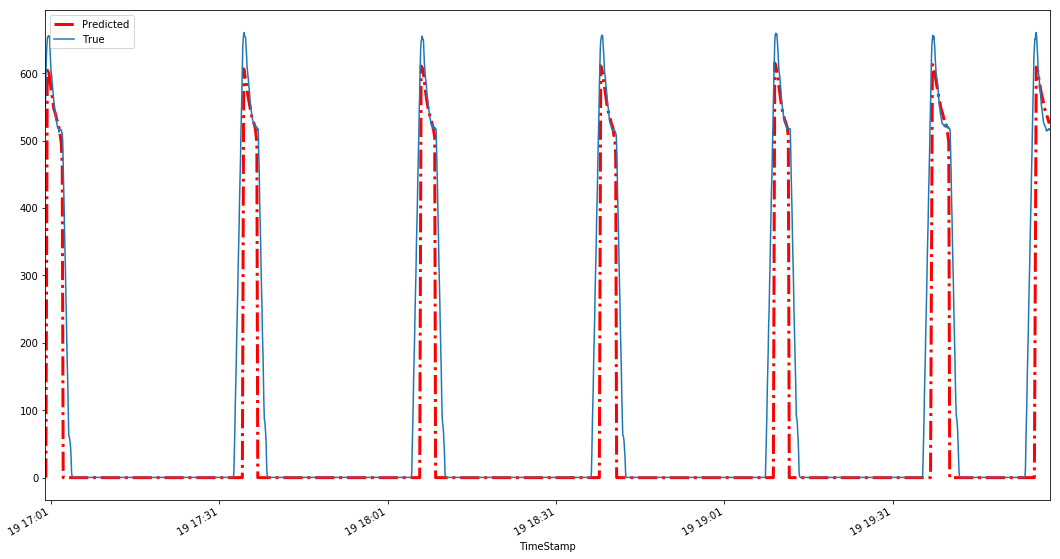

In [291]:
ax = flow_dumb[flow_dumb['Value'].apply(lambda x: isinstance(x, float))].plot(x = 'TimeStamp', y = 'Value',
                                  figsize = (18,10), color = 'r', linewidth = 3, linestyle = "-.")
flow.plot(x = 'TimeStamp', y = 'Value', ax = ax)
ax.legend(['Predicted', "True"])